In [1]:
from dotenv import load_dotenv
load_dotenv()

import os
os.environ["OPENAI_API_KEY"] = os.getenv("OPENAI_API_KEY")
os.environ["HF_API_KEY"] = os.getenv("HF_API_KEY")

In [2]:
from langchain_openai import ChatOpenAI


gptLlm = ChatOpenAI(model_name="o3-mini")

# gptLlm.invoke("What is the capital of France?")

/opt/miniconda3/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
from langchain_huggingface import HuggingFaceEmbeddings
from langchain_community.document_loaders import PyPDFLoader, DirectoryLoader
from langchain_community.vectorstores import Chroma
from langchain_text_splitters import RecursiveCharacterTextSplitter

vectorizer = HuggingFaceEmbeddings(model_name="all-MiniLM-L6-v2")

loader = DirectoryLoader('../resources', glob="**/*.pdf", loader_cls=PyPDFLoader)
documents = loader.load()
# print(documents[0].page_content)

recursiveSplitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=100)
splitDocuments = recursiveSplitter.split_documents(documents)
# splitDocuments[:1]

for doc in splitDocuments:
    print(doc.page_content)


© 2025 ZEUX Innovation | Part of The Insight Advantage Program
The 7-Day Insight 
Mastery Action Plan
Daily practices and reflections to stretch your 
thinking and unlock fresh perspectives
© 2025 ZEUX Innovation | Part of The Insight Advantage Program
• Complete each day's activities in sequence
• Spend 15-30 minutes on daily exercises
• Write reflections in the spaces provided
• Review patterns at the end of each day
• Build on insights from previous days
Note: Some activities might take longer than one day to complete 
fully, and that's perfectly okay. What matters is that you complete 
them - even if it spills into the next day.
How to use this workbook
© 2025 ZEUX Innovation | Part of The Insight Advantage Program
Listen Consciously
Adopt First Principles Thinking
Notice Peripheral Signals
Tune into the Details
Eliminate Functional Fixedness
Refine your Intuition
Nurture Insight 
The LANTERN Framework
© 2025 ZEUX Innovation | Part of The Insight Advantage Program
Theme: Developing

In [4]:
db = Chroma.from_documents(splitDocuments, vectorizer)
retriever = db.as_retriever(search_type="similarity", search_kwargs={"k": 3})
retriever.invoke("What is the insight?")

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


[Document(metadata={'trapped': '/False', 'total_pages': 33, 'page_label': '32', 'creator': 'Adobe InDesign 20.0 (Macintosh)', 'creationdate': '2025-09-19T12:25:36+05:30', 'page': 31, 'producer': 'Adobe PDF Library 17.0', 'source': '../resources/Insights.pdf', 'moddate': '2025-09-19T12:25:40+05:30'}, page_content='© 2025 ZEUX Innovation | Part of The Insight Advantage Program\nRemember: Insight is a muscle. The more you exercise it with \nintentional practice, the stronger it becomes. Use this framework \nas a foundation, but adapt it to your unique \ncontext and challenges.'),
 Document(metadata={'moddate': '2025-09-19T12:25:40+05:30', 'producer': 'Adobe PDF Library 17.0', 'page': 2, 'trapped': '/False', 'source': '../resources/Insights.pdf', 'total_pages': 33, 'creationdate': '2025-09-19T12:25:36+05:30', 'page_label': '3', 'creator': 'Adobe InDesign 20.0 (Macintosh)'}, page_content='© 2025 ZEUX Innovation | Part of The Insight Advantage Program\nListen Consciously\nAdopt First Princip

'''Above is the basic setup for the rag pipeline.'''
'''Next up lets start with Pydantic models.'''

In [5]:
from pydantic import BaseModel, Field

class TopicSectionParser(BaseModel):
    Topic: str = Field(description="The topic that is selected")
    Reasoning: str = Field(description="Reason behind selecting the topic")

In [6]:
from langchain_core.output_parsers import PydanticOutputParser

parser = PydanticOutputParser(pydantic_object=TopicSectionParser)
parser.get_format_instructions()




'The output should be formatted as a JSON instance that conforms to the JSON schema below.\n\nAs an example, for the schema {"properties": {"foo": {"title": "Foo", "description": "a list of strings", "type": "array", "items": {"type": "string"}}}, "required": ["foo"]}\nthe object {"foo": ["bar", "baz"]} is a well-formatted instance of the schema. The object {"properties": {"foo": ["bar", "baz"]}} is not well-formatted.\n\nHere is the output schema:\n```\n{"properties": {"Topic": {"description": "The topic that is selected", "title": "Topic", "type": "string"}, "Reasoning": {"description": "Reason behind selecting the topic", "title": "Reasoning", "type": "string"}}, "required": ["Topic", "Reasoning"]}\n```'

In [7]:
from langchain_core.messages import BaseMessage
from typing import Annotated, Sequence, TypedDict
import operator

class AgentState(TypedDict):
    message: Annotated[Sequence[BaseMessage], operator.add]

AgentState["message"]


__main__.AgentState['message']

#let start creation of node that will handle the user input

In [51]:
from langchain_core.messages import AIMessage

def fun1(state: AgentState):
    # Get the actual text content from the message
    question_text = state["message"][-1] 
    print("question_text", question_text)

    # 1. Define the template with a placeholder {question}
    # Note the use of {{ }} if you have other curly braces in the string
    template = """
    Your task is to classify given user query into one of the following categories: ["Insight Advantage", "Not Related"]. 
    Only return the category name.
    
    user query: {question}
    
    {format_instructions}
    """
    
    # 2. Map the variables correctly
    prompt = PromptTemplate(
        template=template,
        input_variables=["question", "format_instructions"],
    )
    
    chain = prompt | gptLlm | parser
    
    # 3. Pass the values that match the keys in input_variables
    result = chain.invoke({
        "question": question_text,
        "format_instructions": parser.get_format_instructions()
    })

    # FIX: Wrap the result in an AIMessage and put it in a LIST
    # This allows the State reducer to properly append it to the history.
    content_str = f"Topic: {result.Topic}\nReasoning: {result.Reasoning}"
    print("topic", result.Topic)
    # CORRECT: Return a list containing an AIMessage object
    return {"message": [result.Topic]}


In [52]:
def router(state: AgentState):
    last_message = state["message"][-1]
    print(last_message)
    if last_message.lower() == "insight advantage":
        return "RAG call"
    else:
        return "LLM call"

In [71]:
from langchain_core.prompts import PromptTemplate
from langchain_core.output_parsers import StrOutputParser
from langchain_core.runnables import RunnablePassthrough

def format_docs(docs):
    return "\n\n".join(doc.page_content for doc in docs)


def fun2(state: AgentState):
    print("-> RAG Call starts here ->")
    
    # Extract the text content from the last message
    question_text = state["message"][-1]
    
    # 1. REMOVE the 'f' prefix. Use standard string for PromptTemplate
    template = '''You are an assistant for question answer test. 
    Use the following piece of retrieved context to answer the question. 
    If you dont have the answer just say you dont know. 
    Use three sentence max and the answer concise.
    
    Question: {question}
    
    Context: {context}
    '''
    
    prompt = PromptTemplate(
        template=template,
        input_variables=["context", "question"]
    )
    
    # 2. Setup the chain logic
    rag_chain = (
        {
            "context": retriever | format_docs, 
            "question": RunnablePassthrough()
        }
        | prompt
        | gptLlm
        | StrOutputParser()
    )
    
    # 3. Invoke with the string text
    result = rag_chain.invoke(question_text)
    return {"message": [result]}   


In [72]:
def fun3(state: AgentState):
    print("-> LLM Call starts here ->")
    question = state["message"][0]
    
    complete_query = f''' Answer the following with your knowledge: {question} '''
    
    result = gptLlm.invoke(complete_query)
    return {"message": [result.content]}   


In [73]:
'''Now that all the node are ready lets start the communication between then'''

'Now that all the node are ready lets start the communication between then'

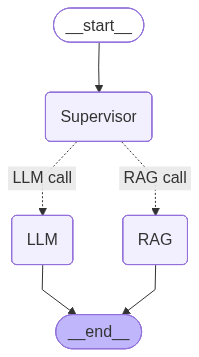

question_text Whats insight advantage?
topic Insight Advantage
Insight Advantage
-> RAG Call starts here ->


{'message': ['Whats insight advantage?',
  'Insight Advantage',
  'Insight Advantage is a program by ZEUX Innovation that serves as a framework to strengthen your insight through intentional practice. It incorporates the LANTERN Framework, emphasizing practices like conscious listening, first principles thinking, and attention to detail. The program also includes a 7-Day Insight Mastery Action Plan designed to unlock fresh perspectives and deepen your intuitive abilities.']}

In [74]:
from langgraph.graph import StateGraph, END
from IPython.display import Image, display

workflow = StateGraph(AgentState)
workflow.add_node("Supervisor", fun1)
workflow.add_node("RAG", fun2)
workflow.add_node("LLM", fun3)
workflow.set_entry_point("Supervisor")

workflow.add_conditional_edges(
    "Supervisor",
    router,
    {
        "RAG call": "RAG",
        "LLM call": "LLM",
    }
)

workflow.add_edge("RAG", END)
workflow.add_edge("LLM", END)

state = {"message": ["Whats insight advantage?"]}

app = workflow.compile()

display(Image(app.get_graph().draw_mermaid_png()))

app.invoke(state)